In [1]:
# Tratamiento de datos
# -----------------------------------------------------------------------
import numpy as np
import pandas as pd

# Otros objetivos
# -----------------------------------------------------------------------
import math

# Gráficos
# -----------------------------------------------------------------------
import seaborn as sns
import matplotlib.pyplot as plt
import plotly.express as px



# Métodos estadísticos
# -----------------------------------------------------------------------
from scipy.stats import zscore # para calcular el z-score
from sklearn.neighbors import LocalOutlierFactor # para detectar outliers usando el método LOF
from sklearn.ensemble import IsolationForest # para detectar outliers usando el metodo IF
from sklearn.neighbors import NearestNeighbors # para calcular la epsilon

# Para generar combinaciones de listas
# -----------------------------------------------------------------------
from itertools import product, combinations

# Gestionar warnings
# -----------------------------------------------------------------------
import warnings
warnings.filterwarnings('ignore')

In [2]:
from src import soporte_outliers as so
from src import soporte_preprocesamiento as sp

In [3]:
df = pd.read_csv("datos/datos_robust.csv",index_col=0)

In [4]:
df.head()

,price,size,municipality,distance,hasVideo,status,hasPlan,has3DTour,floor,hasLift,...,rooms_3,rooms_4,bathrooms_1,bathrooms_2,bathrooms_3,showAddress_False,showAddress_True,has360_False,has360_True,has360_desconocido
0,750.0,0.12,0.445948,-0.252799,0.00000,0.000000,0.000000,0.000000,0.069359,1.000000,...,0.0,0.0,0.0,0.0,0.0,-1.0,1.0,0.0,0.0,0.0
1,750.0,0.52,0.038221,0.182949,1.00000,0.000000,1.000000,0.000000,-0.756628,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,400.0,0.40,-4.512073,2.043824,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.0,0.0,-1.0,1.0,0.0,0.0,0.0,-1.0,1.0,0.0
3,590.0,0.52,-2.098184,2.118218,0.00000,0.000000,0.000000,0.000000,-1.114680,0.000000,...,1.0,0.0,-1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
4,684.0,-0.48,0.445948,-0.079657,-0.67786,-13.120517,-0.374758,-11.538367,-1.114680,-0.952713,...,0.0,0.0,0.0,0.0,0.0,-1.0,1.0,-1.0,0.0,1.0


### Gestión de outliers

Vamos a identificar los outliers univariados. Lo vemos gráfica y analíticamente.

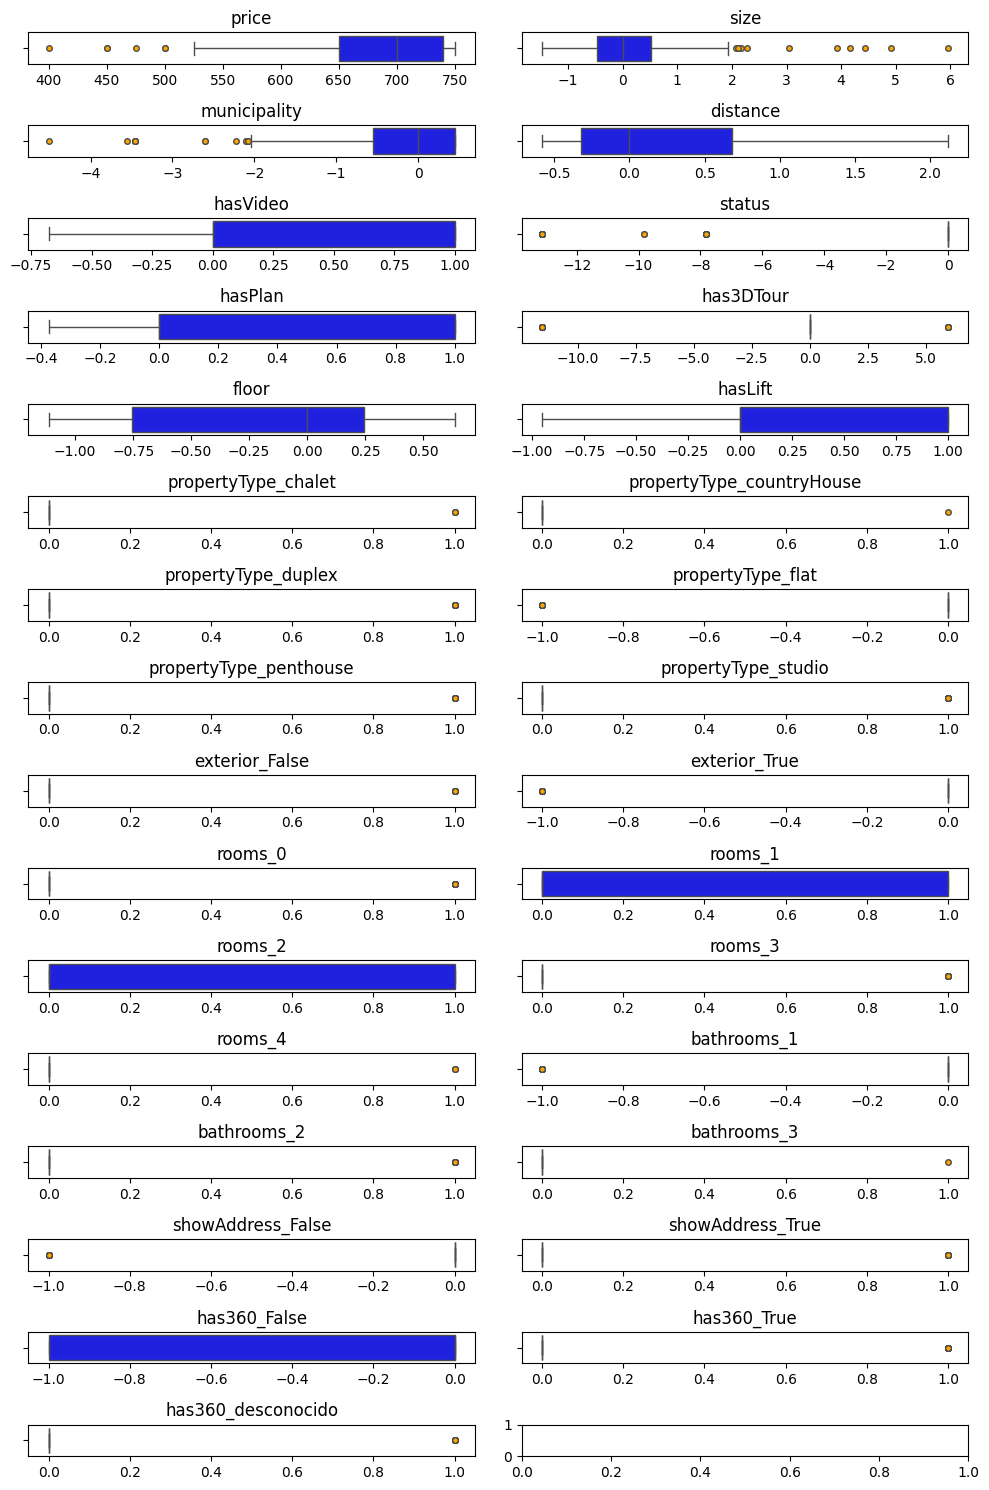

In [5]:
gestion = so.GestionOutliersUnivariados(df)

# llamamos al método que nos permite identificar outliers univariados de forma visual (boxplot)
gestion.visualizar_outliers_univariados()

Vemos outliers en los precios bajos, en las casas de gran tamaño y en los ayuntamientos, probalbemente en los más alejados del centro de Madrid.

In [6]:
so.describe_outliers(df)

,columna,n_outliers,limite_inf,limite_sup,%_outliers
27,showAddress_True,87,0.000000,0.000000,24.65
26,showAddress_False,87,0.000000,0.000000,24.65
29,has360_True,86,0.000000,0.000000,24.36
13,propertyType_flat,76,0.000000,0.000000,21.53
16,exterior_False,68,0.000000,0.000000,19.26
17,exterior_True,68,0.000000,0.000000,19.26
21,rooms_3,52,0.000000,0.000000,14.73
18,rooms_0,49,0.000000,0.000000,13.88
15,propertyType_studio,48,0.000000,0.000000,13.60
23,bathrooms_1,38,0.000000,0.000000,10.76


Vemos que las variables con más porcentaje de outliers son booleanas categorizadas, qeu además cuándo en la fase de encoding hicimos el test A/B salió que no eran ordenadas respecto a la variable respuesta. Esto podría hacerlas candidatas a ser eliminadas del modelo, pero por si acaso las vamos a dejar.

Después vendrían rooms_0 y rooms_3, es decir las casas con 0 y 3 habitaciones respectivamente. Curiosamente, o mejor dicho, lógicamente, vemos que el numero de outliers de la variable rooms_0 y propertyType_studio son casi iguales, pues las casas con 0 habitaciones en buena logica deben ser estudios.

Visualizamos los outliers bivariados

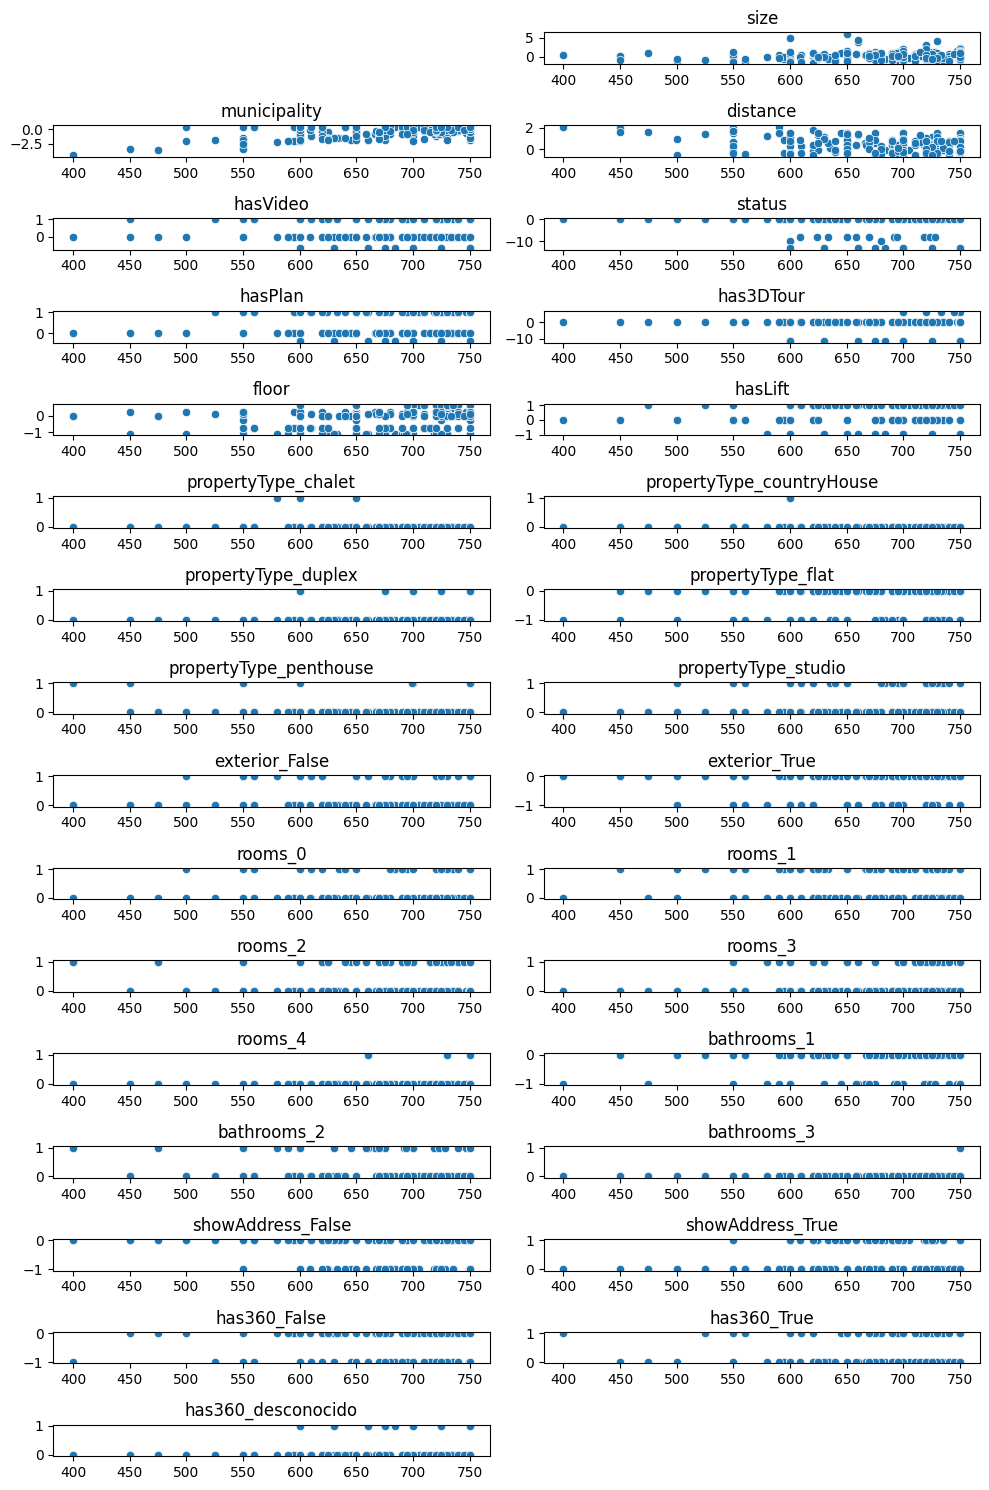

In [7]:
gestion = so.GestionOutliersMultivariados(df)

# llamamos al método que nos permite identificar outliers univariados de forma visual (boxplot)
gestion.visualizar_outliers_bivariados("price")

Como en general no parece haber un gran numero de outlers, ni tampoco están muy densamente concentrados, parece razonable aplicar IF que además es computacionalmente más rápido que LOF.

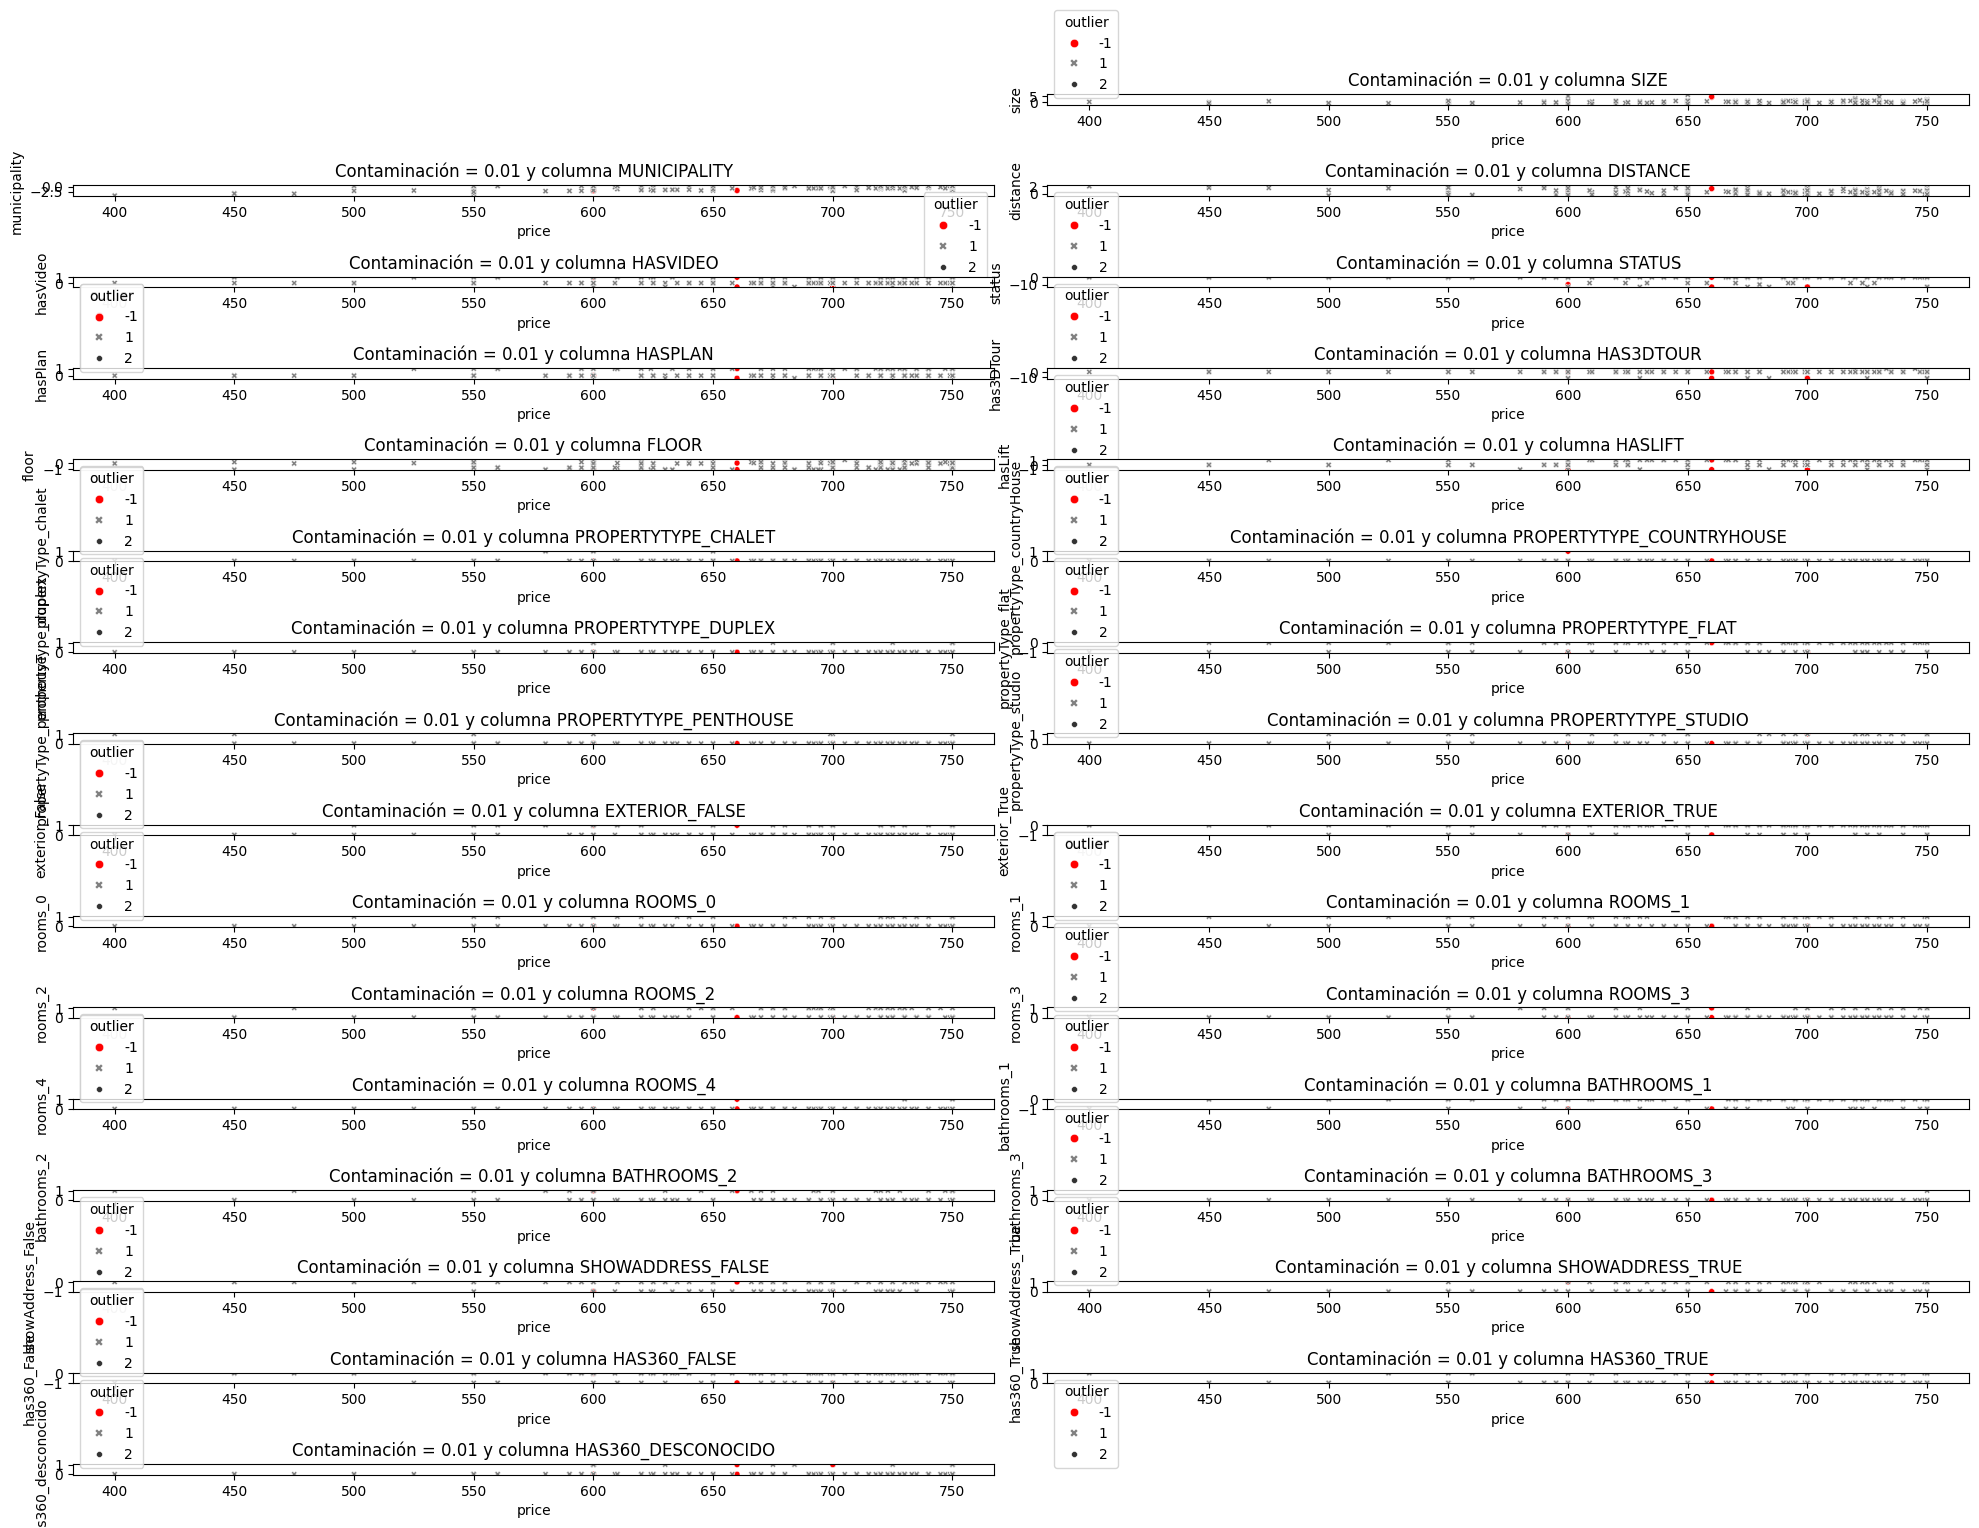

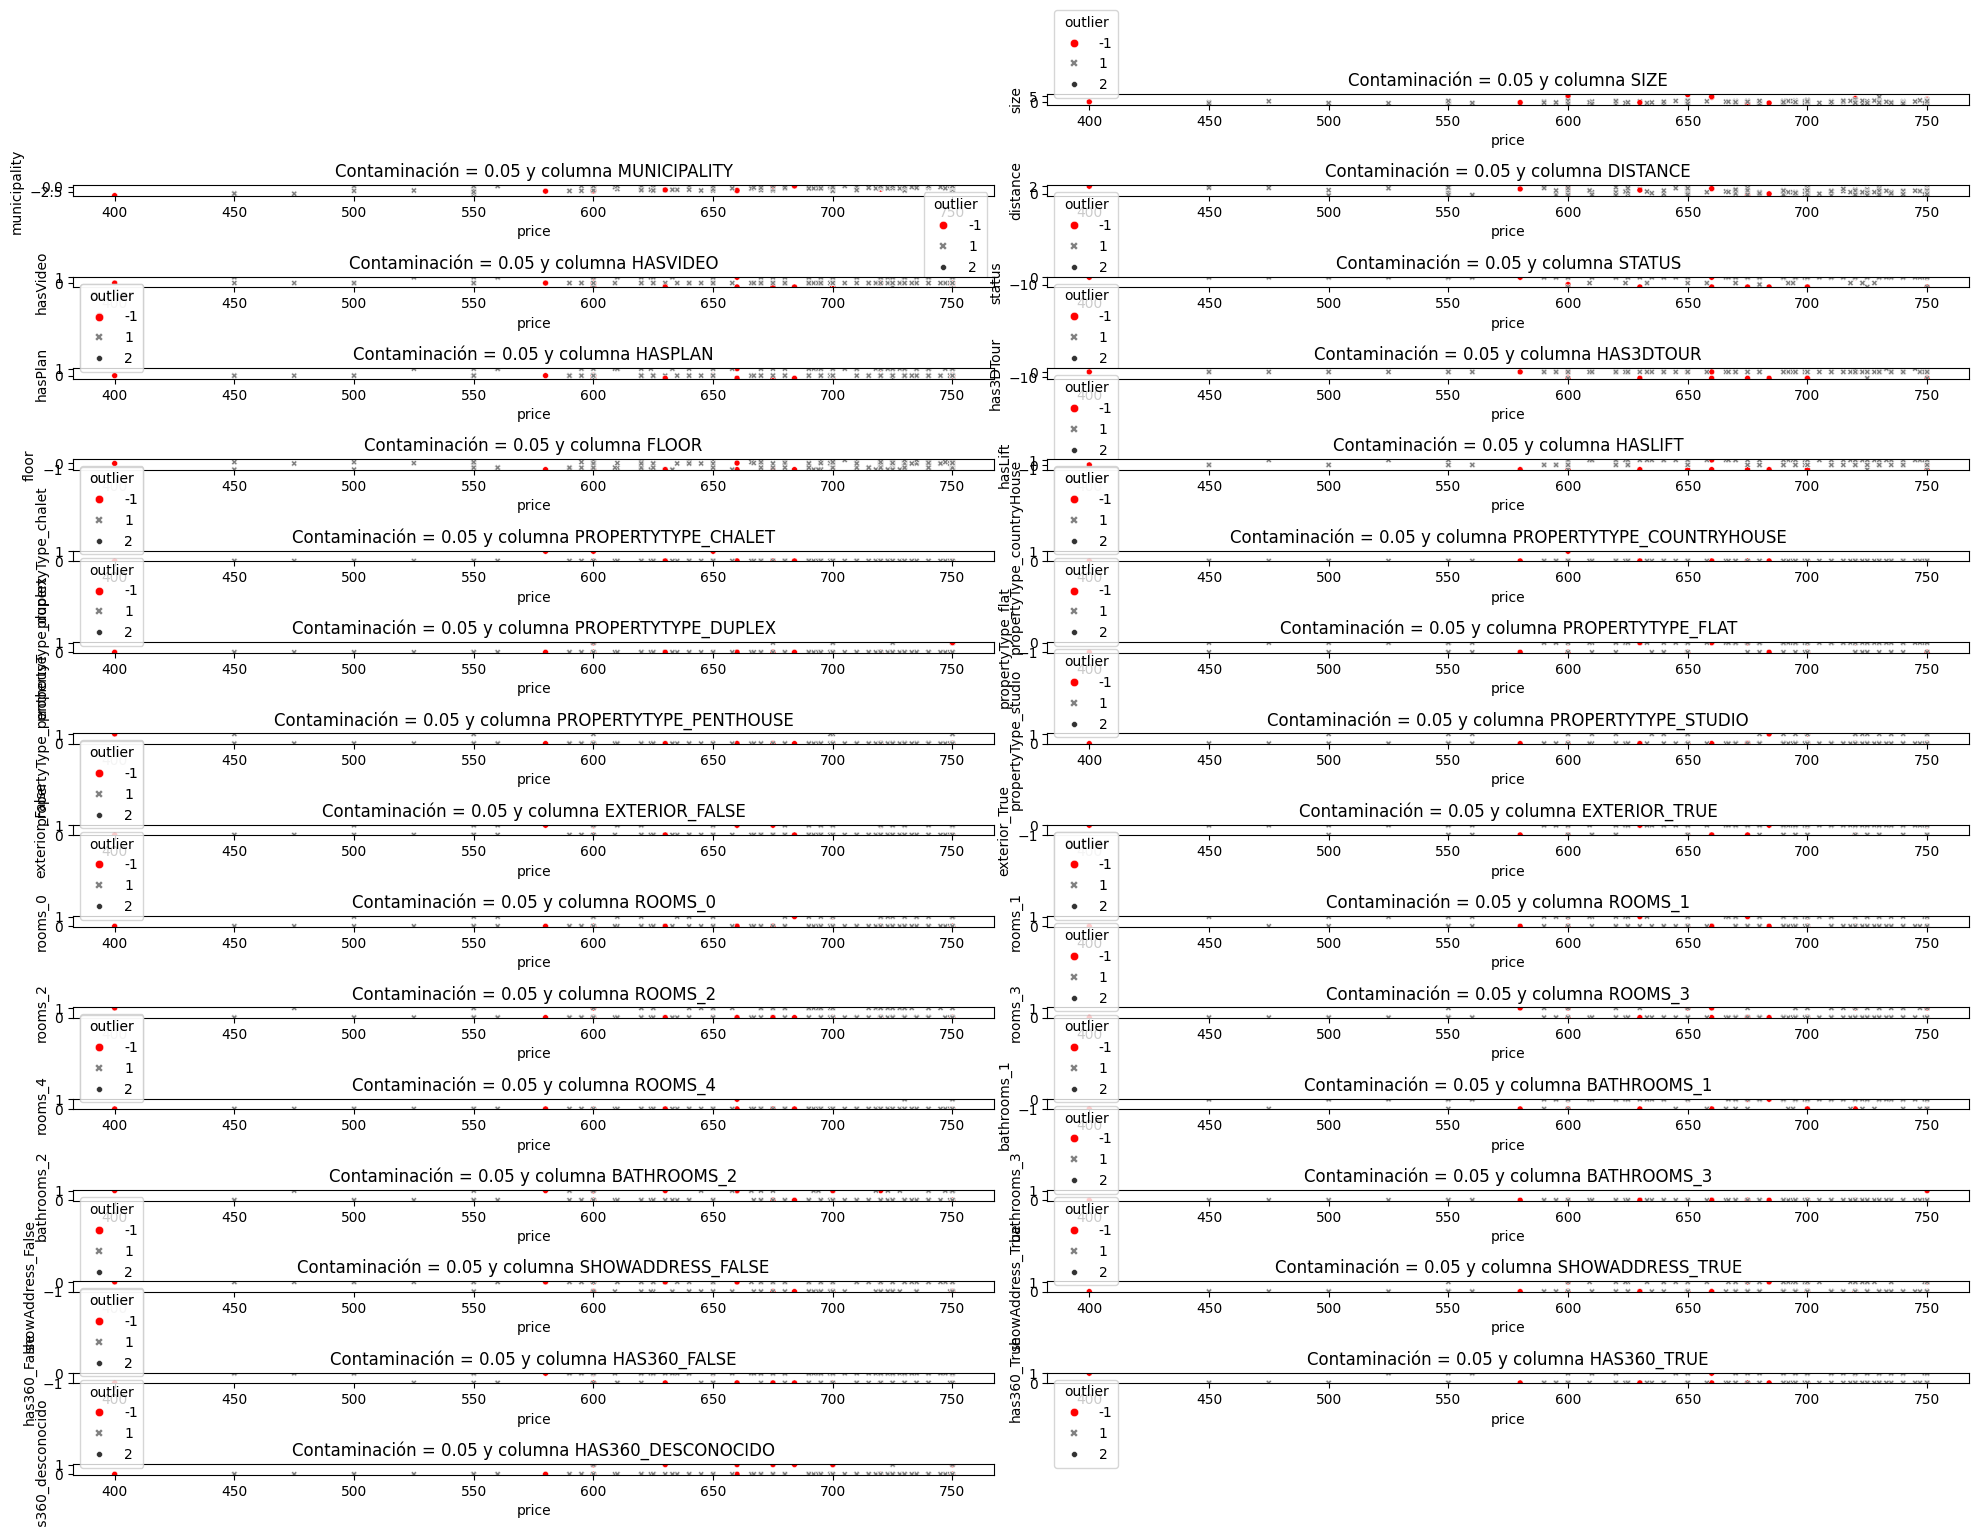

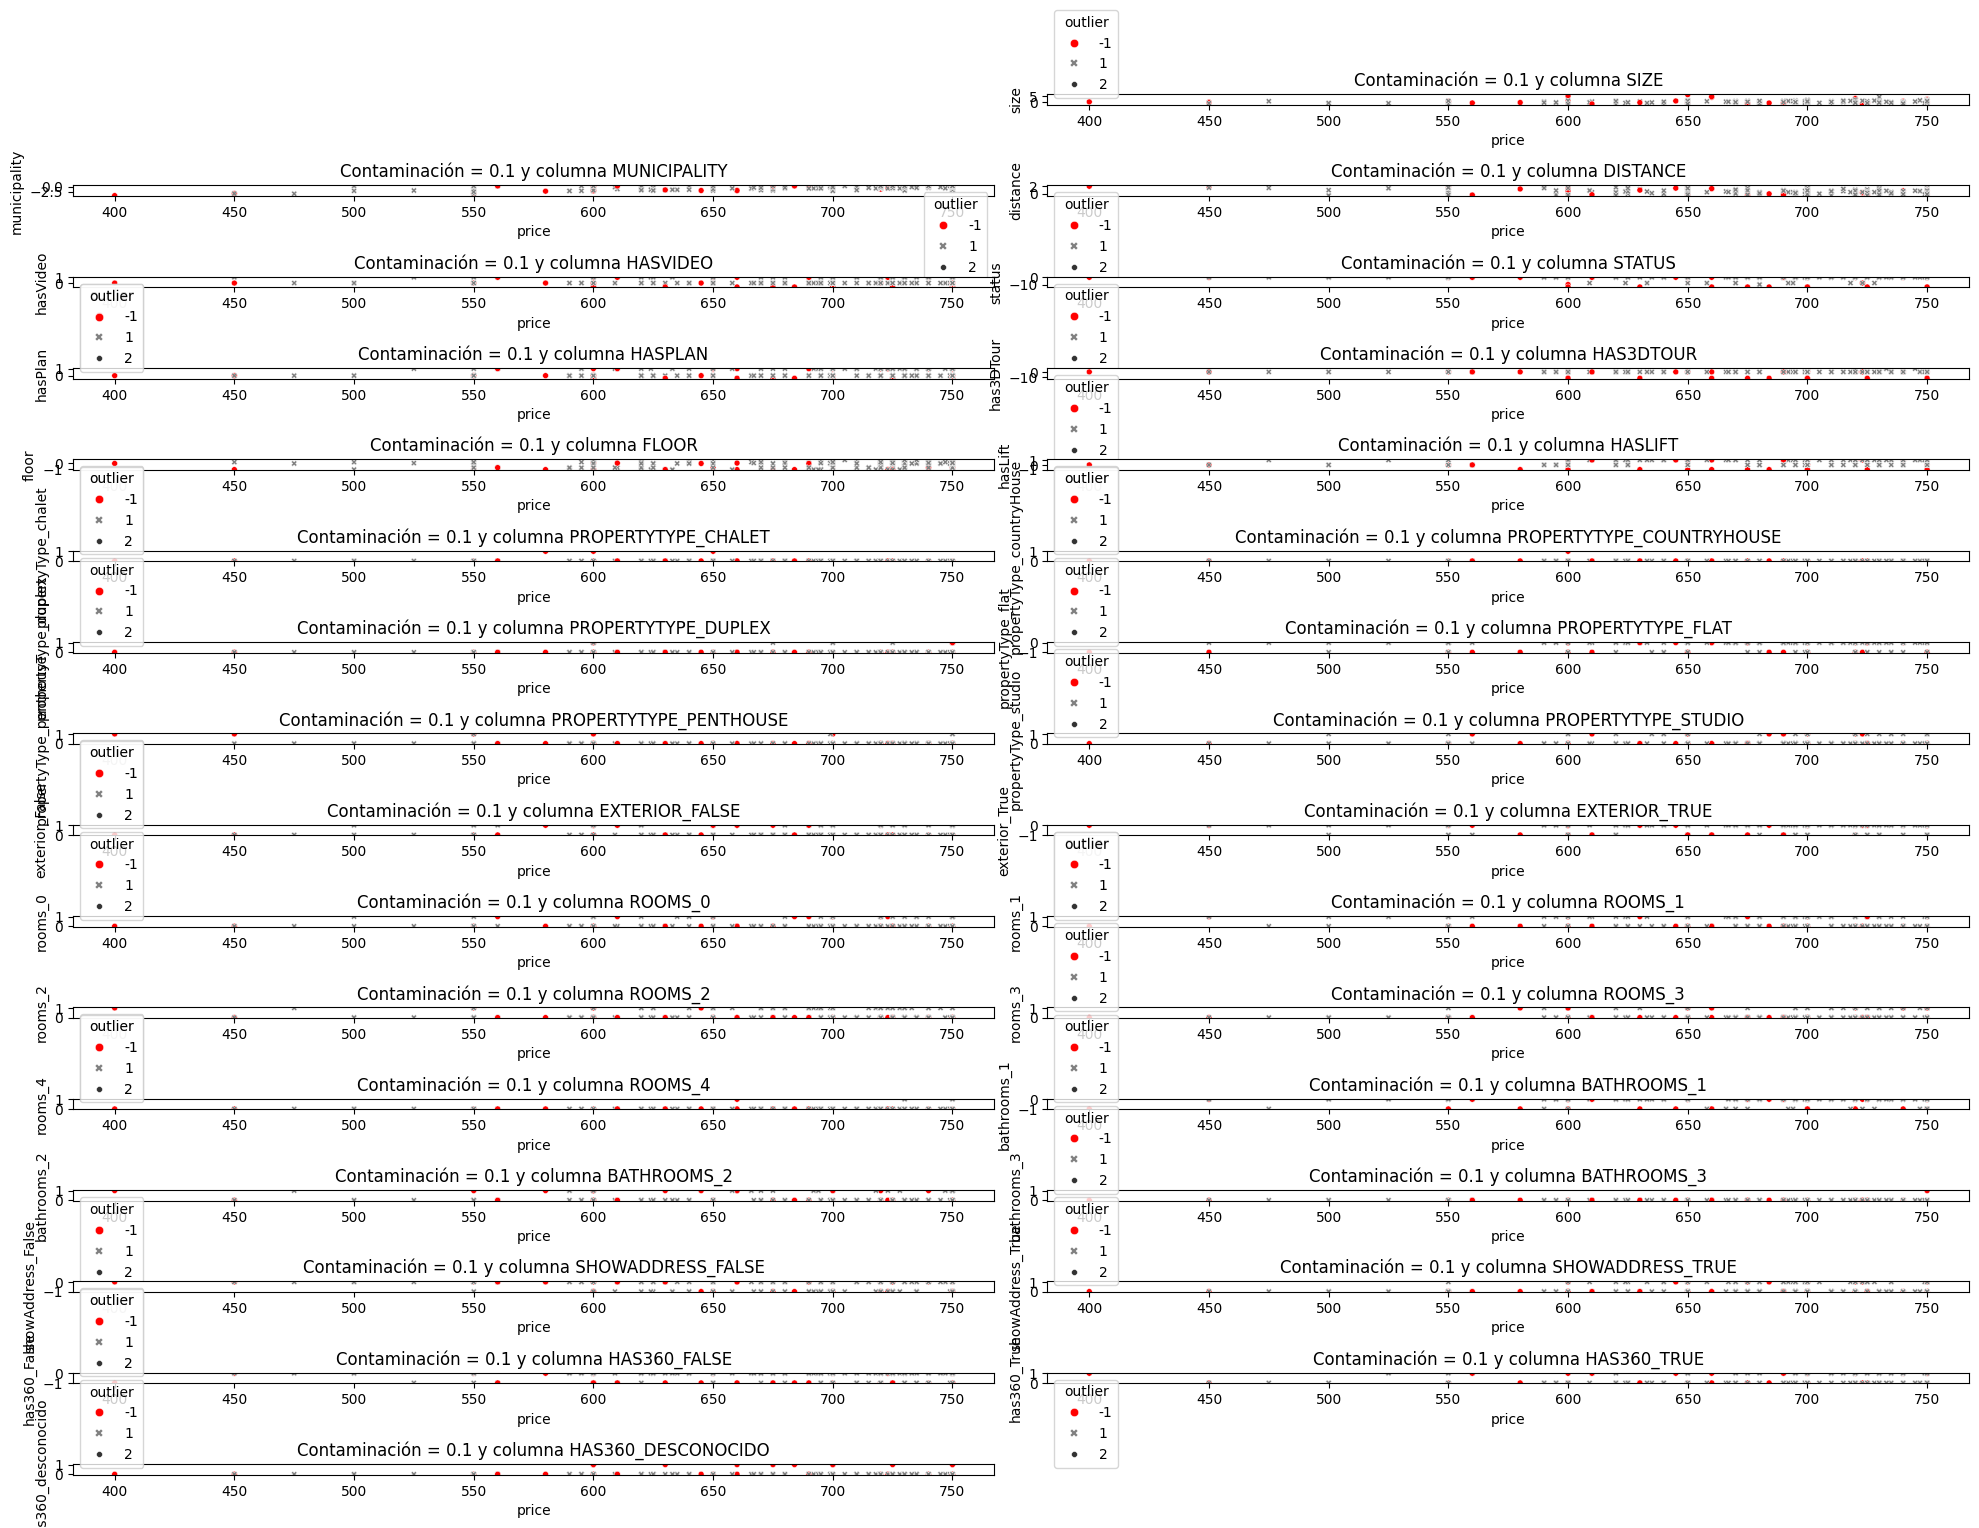

In [8]:
gestion.explorar_outliers_if("price")

In [9]:
df_outliers = gestion.detectar_outliers_if(contaminacion=0.1)

In [10]:
# Imputamos los outliers con la mediana
df_final = gestion.imputar_outliers(data = df_outliers, metodo = "mediana")
df_final.head()

,price,size,municipality,distance,hasVideo,status,hasPlan,has3DTour,floor,hasLift,...,rooms_3,rooms_4,bathrooms_1,bathrooms_2,bathrooms_3,showAddress_False,showAddress_True,has360_False,has360_True,has360_desconocido
0,750.0,0.12,0.445948,-0.252799,0.0,0.0,0.0,0.0,0.069359,1.0,...,0.0,0.0,0.0,0.0,0.0,-1.0,1.0,0.0,0.0,0.0
1,750.0,0.52,0.038221,0.182949,1.0,0.0,1.0,0.0,-0.756628,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,715.0,0.00,0.038221,-0.020333,0.0,0.0,0.0,0.0,0.069359,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,590.0,0.52,-2.098184,2.118218,0.0,0.0,0.0,0.0,-1.114680,0.0,...,1.0,0.0,-1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
4,715.0,0.00,0.038221,-0.020333,0.0,0.0,0.0,0.0,0.069359,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [11]:
df_final.to_csv("datos/datos_preprocesados.csv")